In [2]:
import math

expression_file_content = [line.split("\t") for line in open("../gold_standard_sentences/expression.tsv")]
expression_headers = expression_file_content[0]
expression_data = expression_file_content[1:]

In [3]:
kinaseact_file_content = [line.split("\t") for line in open("../gold_standard_sentences/kinase_activity.tsv")]
kinaseact_headers = kinaseact_file_content[0]
kinaseact_data = kinaseact_file_content[1:]

In [4]:
cleaned_expression_data = []
for row in expression_data:
    if row[2]:
        cleaned_expression_data.append([*row[0:3], "c_elegans" if row[5] != "" else "mixed" if row[6] != "" else "other", "positive" if row[22] != "" else "negative" if row[23] != "" else "both" if row[24] != "" else "neutral", 0 if row[14] != "" else 1 if row[15] != "" else 2 if row[16] != "" else 3 if row[17] != "" else 4 if row[18] != "" else 5 if row[19] != "" else 6 if row[20] != "" else 7])

cleaned_kinaseact_data = []
for row in kinaseact_data:
    if row[2]:
        cleaned_kinaseact_data.append([*row[0:3], "c_elegans" if row[5] != "" else "mixed" if row[6] != "" else "other" if row[7] != "" else "no_species", "positive" if row[22] != "" else "negative" if row[23] != "" else "both" if row[24] != "" else "neutral", 0 if row[14] != "" else 1 if row[15] != "" else 2 if row[16] != "" else 3 if row[17] != "" else 4 if row[18] != "" else 5 if row[19] != "" else 6 if row[20] != "" else 7])

cleaned_headers = ["pmid", "wb_paper_id", "sentence", "species", "result_type", "class"]


In [5]:
from sentence_classification.preprocess import clean_sentences_with_papid, read_sentences_from_file_with_papid
from random import shuffle

neg_sent_otherexpr = read_sentences_from_file_with_papid("../extracted_sentences/neg_sentences_otherexpr.txt")
neg_sent_otherexpr_cleaned = clean_sentences_with_papid(neg_sent_otherexpr)
shuffle(neg_sent_otherexpr_cleaned)



cleaned_expression_data.extend(["", "WBPaper" + row[0], row[1], "", "", 8] for row in neg_sent_otherexpr_cleaned[0:500])

neg_sent_kineaseact = read_sentences_from_file_with_papid("../extracted_sentences/neg_sentences_kinase_activity.txt")
neg_sent_kineaseact_cleaned = clean_sentences_with_papid(neg_sent_kineaseact)
shuffle(neg_sent_kineaseact_cleaned)

cleaned_kinaseact_data.extend(["", "WBPaper" + row[0], row[1], "", "", 8] for row in neg_sent_kineaseact_cleaned[0:500])

In [6]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [7]:
corpus_expr = embedder.encode([row[2] for row in cleaned_expression_data], convert_to_tensor=True)
corpus_kinaseact = embedder.encode([row[2] for row in cleaned_kinaseact_data], convert_to_tensor=True)

In [8]:
import umap

umap_reducer = umap.UMAP(metric='cosine')
corpus_expr_2d = umap_reducer.fit_transform(corpus_expr)
corpus_kinaseact_2d = umap_reducer.fit_transform(corpus_kinaseact)

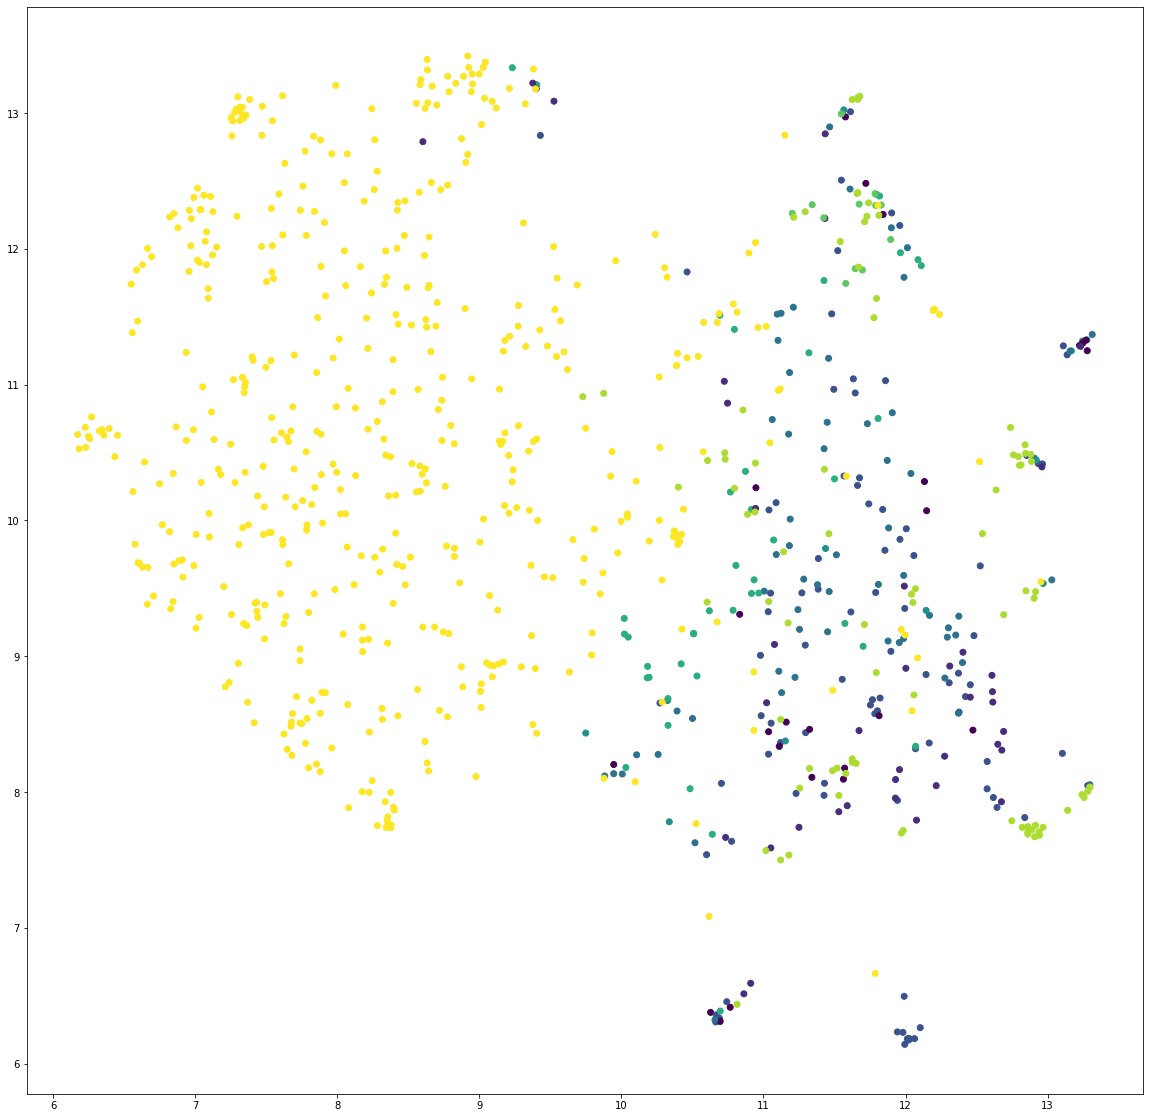

In [9]:
from matplotlib import pyplot as plt

colors_expr = [row[5] for row in cleaned_expression_data]
fig_scatter = plt.figure(figsize=(20, 20))
plt.scatter(x=list(corpus_expr_2d[:,0]), y=list(corpus_expr_2d[:,1]), c=colors_expr)

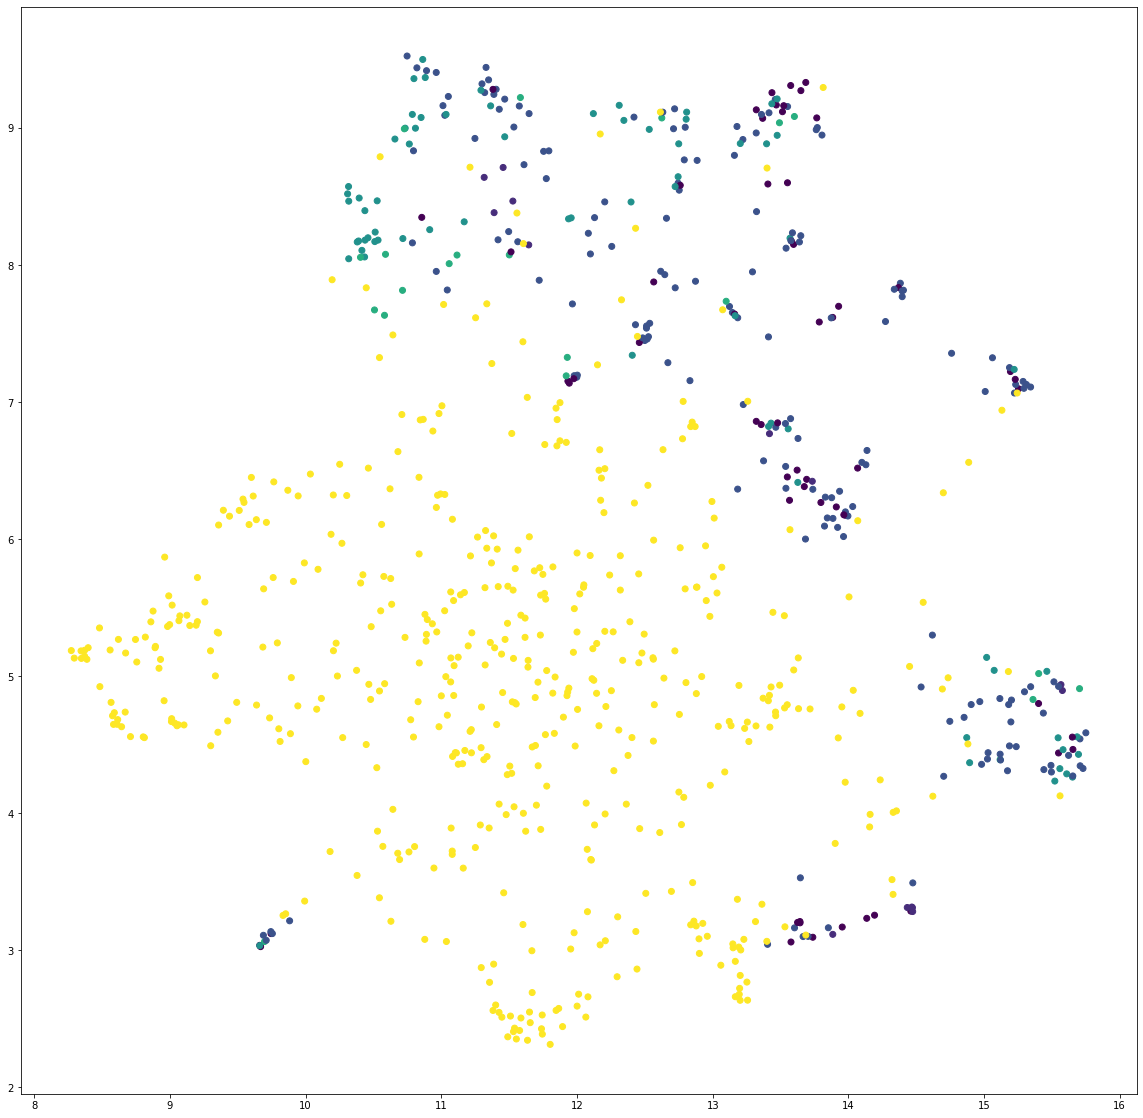

In [10]:
colors_kinaseact = [row[5] for row in cleaned_kinaseact_data]
fig_scatter_kinase = plt.figure(figsize=(20, 20))
plt.scatter(x=list(corpus_kinaseact_2d[:,0]), y=list(corpus_kinaseact_2d[:,1]), c=colors_kinaseact)

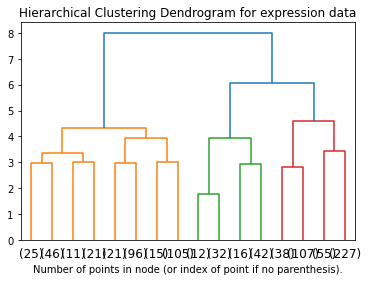

In [11]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


#iris = load_iris()
#X = iris.data
X_expr = corpus_expr

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0.2, n_clusters=None)

model_expr = model.fit(X_expr)
plt.title("Hierarchical Clustering Dendrogram for expression data")
# plot the top three levels of the dendrogram
plot_dendrogram(model_expr, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

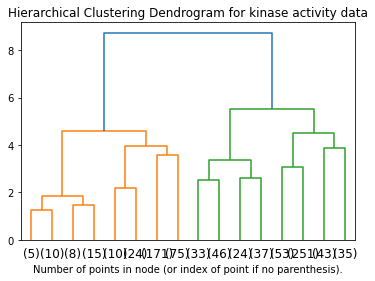

In [12]:
X_kinaseact = corpus_kinaseact

model_kinaseact = model.fit(X_kinaseact)
plt.title("Hierarchical Clustering Dendrogram for kinase activity data")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

# precision and recall using clustering with n_clusters = 2

In [14]:
model_fixed = AgglomerativeClustering(n_clusters=2)
model_fixed_expr = model_fixed.fit(X_expr)
model_fixed_kinaseact = model_fixed.fit(X_kinaseact)
tp_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 1 and cleaned_expression_data[index][5] == 2])
tn_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 0 and cleaned_expression_data[index][5] != 2])
fp_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 1 and cleaned_expression_data[index][5] != 2])
fn_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 0 and cleaned_expression_data[index][5] == 2])
precision_curatable_only_expr = tp_expr / (tp_expr + fp_expr)
recall_curatable_only_expr = tp_expr / (tp_expr + fn_expr)

tp_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 1 and cleaned_kinaseact_data[index][5] == 2])
tn_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 0 and cleaned_kinaseact_data[index][5] != 2])
fp_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 1 and cleaned_kinaseact_data[index][5] != 2])
fn_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 0 and cleaned_kinaseact_data[index][5] == 2])
precision_curatable_only_kinaseact = tp_kinaseact / (tp_kinaseact + fp_kinaseact)
recall_curatable_only_kinaseact = tp_kinaseact / (tp_kinaseact + fn_kinaseact)

tp_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 1 and cleaned_expression_data[index][5] != 8])
tn_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 0 and cleaned_expression_data[index][5] == 8])
fp_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 1 and cleaned_expression_data[index][5] == 8])
fn_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 0 and cleaned_expression_data[index][5] != 8])
precision_any_class_expr = tp_expr / (tp_expr + fp_expr)
recall_any_class_expr = tp_expr / (tp_expr + fn_expr)

tp_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 1 and cleaned_kinaseact_data[index][5] != 8])
tn_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 0 and cleaned_kinaseact_data[index][5] == 8])
fp_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 1 and cleaned_kinaseact_data[index][5] == 8])
fn_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 0 and cleaned_kinaseact_data[index][5] != 8])
precision_any_class_kinaseact = tp_kinaseact / (tp_kinaseact + fp_kinaseact)
recall_any_class_kinaseact = tp_kinaseact / (tp_kinaseact + fn_kinaseact)

tp_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 1 and cleaned_expression_data[index][5] < 7])
tn_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 0 and cleaned_expression_data[index][5] > 6])
fp_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 1 and cleaned_expression_data[index][5] > 6])
fn_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 0 and cleaned_expression_data[index][5] < 7])
precision_no_language_expr = tp_expr / (tp_expr + fp_expr)
recall_no_language_expr = tp_expr / (tp_expr + fn_expr)

tp_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 1 and cleaned_kinaseact_data[index][5] < 7])
tn_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 0 and cleaned_kinaseact_data[index][5] > 6])
fp_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 1 and cleaned_kinaseact_data[index][5] > 6])
fn_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 0 and cleaned_kinaseact_data[index][5] < 7])
precision_no_language_kinaseact = tp_kinaseact / (tp_kinaseact + fp_kinaseact)
recall_no_language_kinaseact = tp_kinaseact / (tp_kinaseact + fn_kinaseact)

print("precision curatable only expression: " + str(precision_curatable_only_expr))
print("recall curatable only expression: " + str(recall_curatable_only_expr))
print("precision curatable only kinase activity: " + str(precision_curatable_only_kinaseact))
print("recall curatable only kinase activity: " + str(recall_curatable_only_kinaseact))

print("precision any class expression: " + str(precision_any_class_expr))
print("recall any class expression: " + str(recall_any_class_expr))
print("precision any class kinase activity: " + str(precision_any_class_kinaseact))
print("recall any class kinase activity: " + str(recall_any_class_kinaseact))

print("precision no language expression: " + str(precision_no_language_expr))
print("recall no language expression: " + str(recall_no_language_expr))
print("precision no language kinase activity: " + str(precision_no_language_kinaseact))
print("recall no language kinase activity: " + str(recall_no_language_kinaseact))

precision curatable only expression: 0.24842767295597484
recall curatable only expression: 0.8777777777777778
precision curatable only kinase activity: 0.48427672955974843
recall curatable only kinase activity: 0.8901734104046243
precision any class expression: 0.9591194968553459
recall any class expression: 0.8265582655826558
precision any class kinase activity: 0.9559748427672956
recall any class kinase activity: 0.8941176470588236
precision no language expression: 0.8081761006289309
recall no language expression: 0.9113475177304965
precision no language kinase activity: 0.9559748427672956
recall no language kinase activity: 0.8941176470588236


# classifiers

In [16]:
from sklearn.neural_network import MLPClassifier
import math

converted_corpus_expr = corpus_expr.numpy()
converted_corpus_kinaseact = corpus_kinaseact.numpy()
indices_expr = [i for i in range(len(corpus_expr))]
shuffle(indices_expr)
training_size_expr = math.ceil(len(corpus_expr) * 0.8)
training_indices_expr = indices_expr[0:training_size_expr]
test_indices_expr = indices_expr[training_size_expr:]
training_set_data_expr = [converted_corpus_expr[index] for index in training_indices_expr]
test_set_classes_expr = [cleaned_expression_data[index][5] for index in test_indices_expr]
indices_kinaseact = [i for i in range(len(corpus_kinaseact))]
shuffle(indices_kinaseact)
training_size_kinaseact = math.ceil(len(corpus_kinaseact) * 0.8)
training_indices_kinaseact = indices_kinaseact[0:training_size_kinaseact]
test_indices_kinaseact = indices_kinaseact[training_size_kinaseact:]
training_set_data_kinaseact = [converted_corpus_kinaseact[index] for index in training_indices_kinaseact]
test_set_classes_kinaseact = [cleaned_kinaseact_data[index][5] for index in test_indices_kinaseact]
base_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

# prediction
## multiclass

In [17]:
from sklearn.metrics import precision_recall_fscore_support as score
training_set_classes_expr = [cleaned_expression_data[index][5] for index in training_indices_expr]
test_set_data_expr = [converted_corpus_expr[index] for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)
test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.         0.5        0.27118644 0.25       0.         0.
 0.         0.5        0.94791667]
recall: [0.         0.08333333 0.8        0.07692308 0.         0.
 0.         0.0625     0.98913043]
fscore: [0.         0.14285714 0.40506329 0.11764706 0.         0.
 0.         0.11111111 0.96808511]
support: [ 3 12 20 13  3 10  4 16 92]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
training_set_classes_kinaseact = [cleaned_kinaseact_data[index][5] for index in training_indices_kinaseact]
test_set_data_kinaseact = [converted_corpus_kinaseact[index] for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)
test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.         0.         0.7037037  0.21428571 0.         0.98989899]
recall: [0.         0.         0.46341463 0.81818182 0.         0.98      ]
fscore: [0.         0.         0.55882353 0.33962264 0.         0.98492462]
support: [  7   4  41  11   5 100]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## binary
### all classes of gold standard sentences considered positive

In [19]:
training_set_classes_expr = [1 if cleaned_expression_data[index][5] != 8 else 0 for index in training_indices_expr]
test_set_classes_expr = [1 if cleaned_expression_data[index][5] != 8 else 0 for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)

test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.97777778 0.95180723]
recall: [0.95652174 0.97530864]
fscore: [0.96703297 0.96341463]
support: [92 81]


In [20]:
training_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][5] != 8 else 0 for index in training_indices_kinaseact]
test_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][5] != 8 else 0 for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)

test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.98019802 0.98507463]
recall: [0.99       0.97058824]
fscore: [0.98507463 0.97777778]
support: [100  68]


### all classes but positive for language - negative for curation and negative sentences

In [22]:
training_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][5] < 7 else 0 for index in training_indices_kinaseact]
test_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][5] < 7 else 0 for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)

test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.98019802 0.98507463]
recall: [0.99       0.97058824]
fscore: [0.98507463 0.97777778]
support: [100  68]


### only directly reports experimental results as positive

In [23]:
training_set_classes_expr = [1 if cleaned_expression_data[index][5] == 2 else 0 for index in training_indices_expr]
test_set_classes_expr = [1 if cleaned_expression_data[index][5] == 2 else 0 for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)

test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.93037975 0.6       ]
recall: [0.96078431 0.45      ]
fscore: [0.94533762 0.51428571]
support: [153  20]


In [32]:
training_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][5] == 2 else 0 for index in training_indices_kinaseact]
test_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][5] == 2 else 0 for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)

test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.90151515 0.77777778]
recall: [0.93700787 0.68292683]
fscore: [0.91891892 0.72727273]
support: [127  41]
